### Digit Recognition Project

In [16]:
import numpy as np
import pandas as pd

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier

import matplotlib.pyplot as plt

### Data Loading and Exploration

In [17]:
labeled_images = np.load("data/labeled_images.npy")
labeled_digits = np.load("data/labeled_digits.npy")
autograder_images = np.load("data/autograder_images.npy")

In [18]:
# This is an array containing all the 3750 images of size 28 times 28 pixels:
labeled_images.shape

(3750, 28, 28)

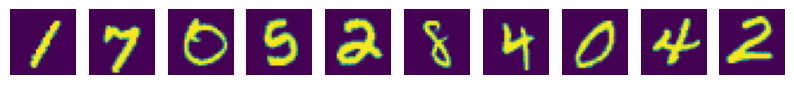

In [19]:
num_images = 10
plt.figure(figsize=(10, 2))

for i in range(num_images):
    image = labeled_images[i]
    plt.subplot(1, num_images, i + 1)
    plt.imshow(image)
    plt.axis('off')
plt.show()

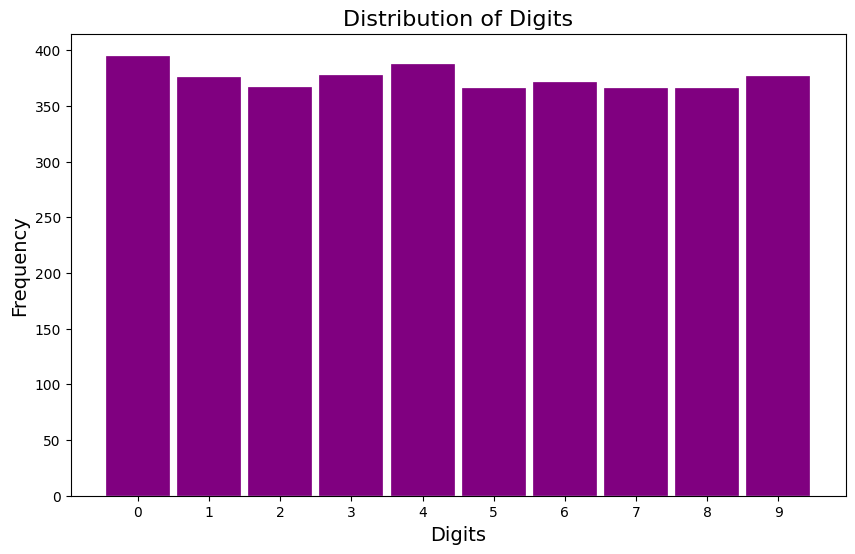

In [20]:
# Understanding the data distribution

digits, counts = np.unique(labeled_digits, return_counts=True)
fig, ax = plt.subplots(figsize=(10, 6)) 

ax.bar(digits, counts, width=0.9, edgecolor="white", linewidth=0.2, color="purple")
ax.set_title('Distribution of Digits', fontsize=16)  
ax.set_xlabel('Digits', fontsize=14)
ax.set_ylabel('Frequency', fontsize=14)
ax.set_xticks(digits)

# Observation: Equal distribution of classes (in this problem, our classes are digits). We have a balanced dataset.

In [21]:
# This is an array containing the digit corresponding to each image:
labeled_digits[0:100]

array([1, 7, 0, 5, 2, 8, 4, 0, 4, 2, 2, 3, 4, 7, 2, 8, 0, 9, 2, 5, 4, 1,
       1, 6, 3, 6, 4, 9, 9, 7, 2, 4, 5, 1, 5, 7, 0, 4, 4, 6, 3, 0, 6, 5,
       0, 9, 7, 8, 0, 6, 1, 8, 4, 8, 9, 1, 4, 8, 0, 0, 7, 9, 1, 8, 9, 3,
       4, 9, 0, 5, 9, 6, 4, 0, 9, 4, 0, 6, 3, 1, 8, 9, 0, 8, 0, 1, 6, 4,
       4, 6, 1, 2, 7, 2, 0, 0, 5, 9, 2, 7])

In [22]:
if len(labeled_images.shape) == 4 and labeled_images.shape[-1] == 3:
    print("Labeled images are in RGB!")
elif len(labeled_images.shape) == 3:
    print("Labeled images are already in grayscale!")

# Observation: The dataset is already in grayscale. It does not have any color channels, it is 2-dimensional.
# No conversion from RGB to grayscale is needed!

Labeled images are already in grayscale!


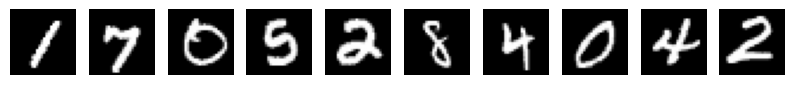

In [23]:
num_images = 10
plt.figure(figsize=(10, 2))

for i in range(num_images):
    image = labeled_images[i]
    plt.subplot(1, num_images, i + 1)
    plt.imshow(image, cmap='gray')
    plt.axis('off')
plt.show()

### Data Preprocessing

In [29]:
# Normalization using Tensors

from PIL import Image
import torch
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms

def get_mean_std(loader):
    # Compute the mean and standard deviation of all pixels in the dataset
    num_pixels = 0
    mean = 0.0
    std = 0.0
    for images, _ in loader:
        batch_size, num_channels, height, width = images.shape
        num_pixels += batch_size * height * width
        mean += images.mean(axis=(0, 2, 3)).sum()
        std += images.std(axis=(0, 2, 3)).sum()

    mean /= num_pixels
    std /= num_pixels

    return mean, std

data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Step 1: Create a Tensor dataset out of the images
input = labeled_images
labels = labeled_digits

images = torch.stack([data_transforms(Image.fromarray(image)) for image in labeled_images])
labels = torch.tensor([label for label in labeled_digits])
dataset = TensorDataset(images, labels)

# Step 2: Calculate the mean and standard deviation of the dataset
batch_size = 32
loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
mean, std = get_mean_std(loader)

print(f"Before Normalization - Mean: {mean}, Std: {std}")

# Step 3: Normalize the dataset
normalized_data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

images = torch.stack([normalized_data_transforms(Image.fromarray(image)) for image in labeled_images])
dataset = TensorDataset(images, labels)

# Verify normalization
batch_size = 32
loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
normal_mean, normal_std = get_mean_std(loader)

print(f"After Normalization - Mean: {normal_mean}, Std: {normal_std}")


Before Normalization - Mean: 8.26398149911256e-08, Std: 1.819127248836594e-07
After Normalization - Mean: 0.4554664194583893, Std: 1.0010827779769897


In [24]:
# Another Normalization Approach

from sklearn import preprocessing

pixel_size = labeled_images.shape[1] 
data_size = labeled_images.shape[0]

X = labeled_images.reshape(data_size, pixel_size * pixel_size)
X = labeled_images.reshape(labeled_images.shape[0], -1)
print("Original shape after reshaping:", X.shape)

original_means = X.mean(axis=0)
original_stds = X.std(axis=0)
print("Before Normalization - Mean:", original_means.mean())
print("Before Normalization - Std:", original_stds.mean())

scaler = preprocessing.StandardScaler().fit(X)
X_processed = scaler.transform(X)
print("\nNormalized shape:", X_processed.shape)

normalized_means = X_processed.mean(axis=0)
normalized_stds = X_processed.std(axis=0)
print("After Normalization - Mean:", normalized_means.mean())
print("After Normalization - Std:", normalized_stds.mean())

Original shape after reshaping: (3750, 784)
Before Normalization - Mean: 33.6080537414966
Before Normalization - Std: 49.140110944971326

Normalized shape: (3750, 784)
After Normalization - Mean: -4.36451116177794e-20
After Normalization - Std: 0.8380102040816332


### Baseline Model: Majority Class Classifier

As a reference point for our upcoming models, we chose to implement a Majority Class Classifier that predicts the most frequent class in the training set.

In [25]:
digits, counts = np.unique(labeled_digits, return_counts=True)
most_frequent_digit = digits[np.argmax(counts)]

print(f"The most frequent digit is: {most_frequent_digit}")
print(f"All images will be classified as {most_frequent_digit}...")

accuracy = counts[most_frequent_digit] / labeled_digits.shape[0]
print(f"Accuracy of the Majority Class Classifier: {accuracy}")

The most frequent digit is: 0
All images will be classified as 0...
Accuracy of the Majority Class Classifier: 0.10533333333333333


### Logistic Classifier with Default Parameters

Documentation: https://scikit-learn.org/1.5/modules/generated/sklearn.linear_model.SGDClassifier.html#sklearn.linear_model.SGDClassifier

In [12]:
# Preparing the data for training

from sklearn.model_selection import train_test_split

pixel_size = labeled_images.shape[1] 
data_size = labeled_images.shape[0]

X = labeled_images.reshape(labeled_images.shape[0], -1)
y = labeled_digits
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=0) 

In [13]:
from sklearn.linear_model import SGDClassifier

# SGDClassifier with loss='log_loss' is equivalent to logistic regression trained with SGD
# Default: max_iter = 1000
logistic_clf = SGDClassifier(loss='log_loss', random_state=0)

logistic_clf.fit(X_train, y_train)
y_pred = logistic_clf.predict(X_train)
accuracy = np.mean(y_pred == y_train)
print('Logistic Classifier - Accuracy on the training set:', accuracy)

y_pred = logistic_clf.predict(X_test)
accuracy = np.mean(y_pred == y_test)
print('Logistic Classifier - Accuracy on the test set:', accuracy)

Logistic Classifier - Accuracy on the training set: 0.9653333333333334
Logistic Classifier - Accuracy on the test set: 0.8853333333333333


### Tuning Logictic Classifier with Grid Search

**Remarks about Logistic Classifier before Hyperparameter Tuning**

Realize that without hyperparameter tuning, logistic classifier with stochastic gradient descent (SGD) is undergoing **overfitting**. 

In [22]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'penalty': ['l2', 'l1'], # regularization type 
    'alpha': [0.0001, 0.001, 0.01], # regularization strength
    'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive']
}

clf = SGDClassifier(loss='log_loss', random_state=0)

grid_search = GridSearchCV(clf, param_grid, cv=5)
grid_search.fit(X_train, y_train)

print("Best parameters for SGD Classifier:", grid_search.best_params_)

KeyboardInterrupt: 

In [105]:
best_params = grid_search.best_params_
logistic_clf_best = SGDClassifier(loss='log_loss', random_state=0, **best_params)

logistic_clf_best.fit(X_train, y_train)
y_pred = logistic_clf_best.predict(X_train)
accuracy = np.mean(y_pred == y_train)
print('Logistic Classifier - Accuracy on the training set:', accuracy)

y_pred = logistic_clf_best.predict(X_test)
accuracy = np.mean(y_pred == y_test)
print('Logistic Classifier - Accuracy on the test set:', accuracy)

Logistic Classifier - Accuracy on the training set: 0.9063333333333333
Logistic Classifier - Accuracy on the test set: 0.8693333333333333


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Observe that overfitting is significantly reduced after hyperparameter tuning. The accuracy on the training and test sets are now closer to each other. 

### Traning Curve for Logistic Classifier

In [18]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

pixel_size = labeled_images.shape[1] 
data_size = labeled_images.shape[0]

X = labeled_images.reshape(data_size, pixel_size * pixel_size)
y = labeled_digits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0) # Split further into validation dataset

max_iters = 75
clf = SGDClassifier(loss='log_loss', max_iter=max_iters, **best_params, tol=None, random_state=0, warm_start=True)

train_accs = []
val_accs = []

patience = 75 # Without early stopping
val_acc_best = 0
patience_cnt = 0

for epoch in range(max_iters):
    clf.fit(X_train, y_train)  # Incremental training for writing the training curve implementation

    y_train_pred = clf.predict(X_train)
    y_val_pred = clf.predict(X_val)

    train_acc = accuracy_score(y_train, y_train_pred) * 100
    val_acc = accuracy_score(y_val, y_val_pred) * 100

    train_accs.append(train_acc)
    val_accs.append(val_acc)

    # Early stopping implementation
    if val_acc > val_acc_best:
        val_acc_best = val_acc
        patience_cnt = 0
    else:
        patience_cnt +=1
        if patience_cnt == patience:
            break

y_test_pred = clf.predict(X_test)
test_acc = accuracy_score(y_test, y_test_pred)
print(f'Final Test Accuracy: {test_acc}')

# Training curve
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_accs) + 1), train_accs, label='Train Accuracy', marker='o')
plt.plot(range(1, len(val_accs) + 1), val_accs, label='Validation Accuracy', linestyle='--', marker='x')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training Curve: Accuracy vs. Epochs')
plt.ylim(0, 100) 
plt.legend()
plt.grid()
plt.show()

NameError: name 'best_params' is not defined

### SVM Classifier with Default Parameters

In [33]:
from sklearn.model_selection import cross_val_score

svm_clf = SVC(random_state=0)

cv_scores = cross_val_score(svm_clf, X_train, y_train, cv=10, scoring='accuracy')
print("Cross-Validation Scores:", cv_scores)
print("Average Accuracy:", cv_scores.mean())

# Test
svm_clf.fit(X_train, y_train)
test_accuracy = svm_clf.score(X_test, y_test)
print("Test set accuracy:", test_accuracy)

Cross-Validation Scores: [0.93333333 0.96       0.93333333 0.95333333 0.93333333 0.93666667
 0.95666667 0.93333333 0.93333333 0.92333333]
Average Accuracy: 0.9396666666666669
Test set accuracy: 0.952


### Tuning SVM with Grid Search

In [ ]:
from sklearn.model_selection import KFold, GridSearchCV

#svm_clf.get_params()
inner_cv = KFold(n_splits=10, random_state=0, shuffle=True)
outer_cv = KFold(n_splits=5, random_state=0, shuffle=True)
svm_grid = {"C": [0.01, 0.1, 1, 10],
            "kernel": ["poly", "rbf"],
            "gamma": [0.001, 0.01, 0.1, "scale"]
            }

svm = SVC(random_state=0)
svm_grid_clf = GridSearchCV(estimator=svm, param_grid=svm_grid, cv=inner_cv)

# nested_scores = cross_val_score(svm_grid_clf, X=svmX_train, y=svmY_train, cv=outer_cv, scoring='accuracy')
# print("Nested Cross-Validation Scores:", nested_scores)
# print("Average Nested CV Score:", nested_scores.mean())

svm_grid_clf.fit(X_train, y_train)
svm_best_params = svm_grid_clf.best_params_
print("Best Parameters for SVM:", svm_best_params)

svm_best_cv_score = svm_grid_clf.best_score_
print("Best CV Score for SVM:", svm_best_cv_score)

svm_tune_test_accuracy = svm_grid_clf.score(X_test, y_test)
print("Test Set Accuracy:", svm_tune_test_accuracy)

Best Parameters for SVM: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best CV Score for SVM: 0.9423333333333334
Test Set Accuracy: 0.96


### KNN Classifier

Following: https://www.datacamp.com/tutorial/k-nearest-neighbor-classification-scikit-learn

In [66]:
import statistics
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score

X = labeled_images.reshape(labeled_images.shape[0], -1)
y = labeled_digits
# train 80% test 20% with normalized data set
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=7)

# scale the features using StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### KNN with Default Parameters

In [67]:
knn_clf_default = KNeighborsClassifier()
knn_clf_default.fit(X_train, y_train)

y_train_pred = knn_clf_default.predict(X_train)
accuracy = accuracy_score(y_train, y_train_pred)
print("KNN default - Training set accuracy:", accuracy)

y_test_pred = knn_clf_default.predict(X_test)
accuracy = accuracy_score(y_test, y_test_pred)
print("KNN default - Test set accuracy:", accuracy)

KNN default - Training set accuracy: 0.9206666666666666
KNN default - Test set accuracy: 0.848


### Tuning KNN Classifier

Average Accuracy: 0.8357944444444444
The best k: 3
KNN tuned - Training set accuracy: 0.9356666666666666
KNN tuned - Test set accuracy: 0.8666666666666667


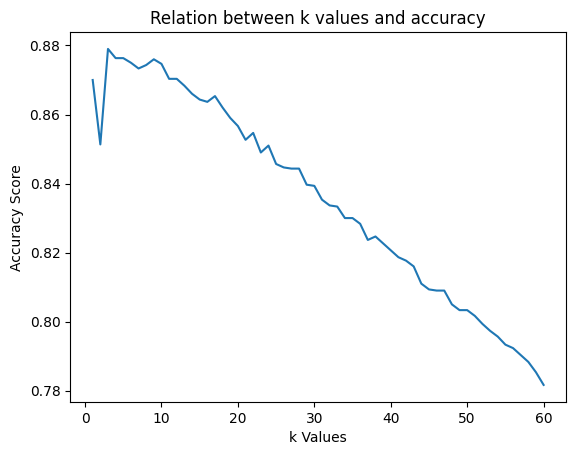

In [68]:
k_values = [i for i in range(1, 61)]
scores = []
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    score = cross_val_score(knn, X_train, y_train, cv=5)
    scores.append(np.mean(score))

# see relation between k values and accuracy
plt.plot(k_values, scores)
plt.xlabel("k Values")
plt.ylabel("Accuracy Score")
plt.title("Relation between k values and accuracy")
print("Average Accuracy:", statistics.mean(scores))

# choose the k value that maximizes accuracy
best_index = np.argmax(scores)
best_k = k_values[best_index]
print("The best k:", best_k)

knn_clf = KNeighborsClassifier(n_neighbors=best_k)
knn_clf.fit(X_train, y_train)

y_train_pred = knn_clf.predict(X_train)
accuracy = accuracy_score(y_train, y_train_pred)
print("KNN tuned - Training set accuracy:", accuracy)

y_test_pred = knn_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_test_pred)
print("KNN tuned - Test set accuracy:", accuracy)

### Decision Tree Classifier with Default Parameters

In [27]:
tree_clf = DecisionTreeClassifier(random_state=0)

tree_cv_scores = cross_val_score(tree_clf, X_train, y_train, cv=10, scoring='accuracy')
print("Decision Tree Cross-Validation Scores:", tree_cv_scores)
print("Decision Tree Average Accuracy:", tree_cv_scores.mean())

tree_clf.fit(X_train, y_train)
tree_test_accuracy = tree_clf.score(X_test, y_test)
print("Decision Tree Test set accuracy:", tree_test_accuracy)

Decision Tree Cross-Validation Scores: [0.7        0.71       0.72666667 0.73       0.73       0.72
 0.76333333 0.7        0.75666667 0.7       ]
Decision Tree Average Accuracy: 0.7236666666666667
Decision Tree Test set accuracy: 0.744


### Tuning Decision Tree with Grid Search

In [28]:
from sklearn.model_selection import KFold, GridSearchCV

#tree_clf.get_params()
tree_grid = {"max_depth": [None, 5, 10, 20],
             "min_samples_leaf": [1, 2, 5],
             "min_samples_split": [2, 5, 10],
             "criterion": ["gini", "entropy"]
             }

dt = DecisionTreeClassifier(random_state=0)
tree_grid_clf = GridSearchCV(estimator=dt, param_grid=tree_grid, cv=10)
tree_grid_clf.fit(X_train, y_train)

tree_best_params = tree_grid_clf.best_params_
print("Best Parameters for Decision Tree:", tree_best_params)

tree_best_cv_score = tree_grid_clf.best_score_
print("Best CV Score for Decision Tree:", tree_best_cv_score)

tree_tune_test_accuracy = tree_grid_clf.score(X_test, y_test)
print("Test Set Accuracy:", tree_tune_test_accuracy)

Best Parameters for Decision Tree: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5}
Best CV Score for Decision Tree: 0.754
Test Set Accuracy: 0.7453333333333333


### Visualization of Decision Tree 

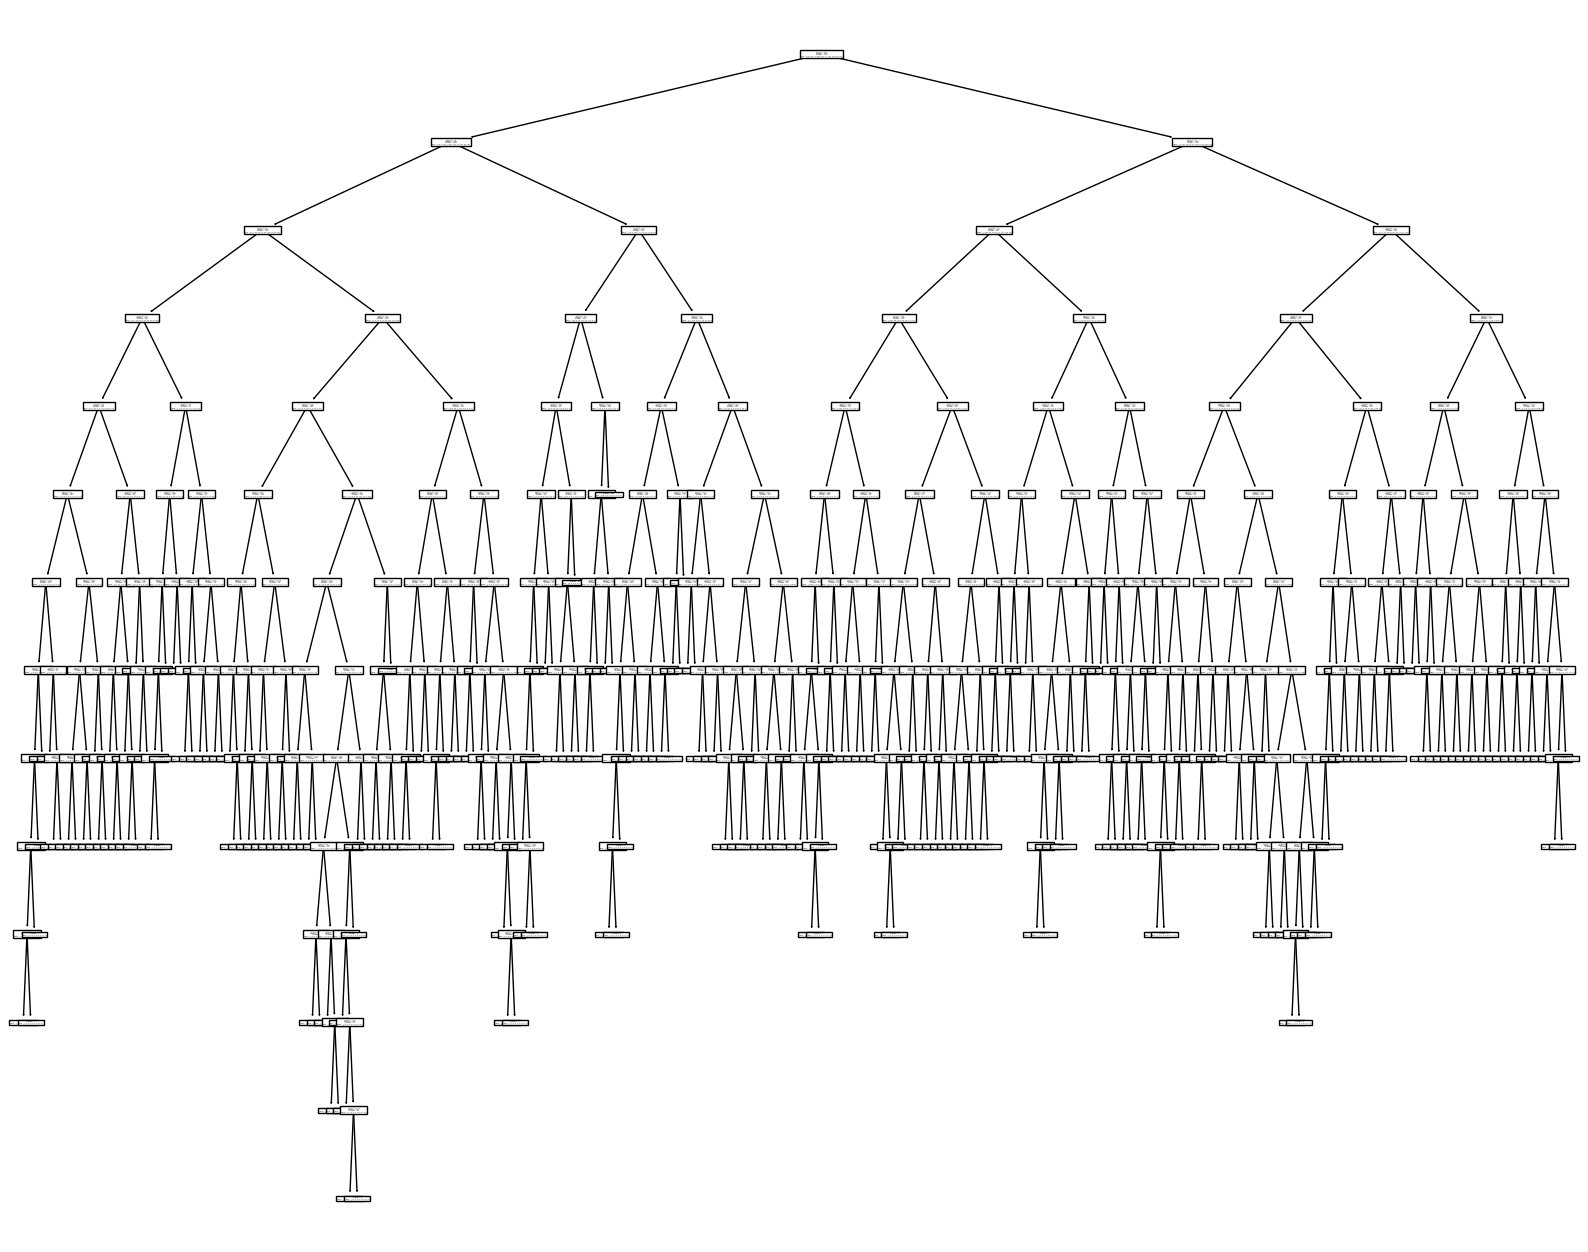

In [38]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

best_tree = tree_grid_clf.best_estimator_
plt.figure(figsize=(20, 16))
plot_tree(best_tree)
plt.show()

### Prepare autograder submission

In the autograder you will need to provide two things: 1) estimate of the accuracy of your model on unseen data, 2) the predictions on the autograder images. For the autograder images we only provide the images and not the class labels. Thus, you cannot compute the accuracy on this data yourself - you need to estimate that with labeled data that is provided (labeled_images, labeled_digits). We will calculate the accuracy for you on the autograder data and you will receive an automatic grade based on this. 

In [39]:
estimate = np.array([0.960]) # TODO Replace this with your estimate of the accuracy on new data
#prediction = np.array([-1] * len(autograder_images)) # TODO Replace this with your predictions of your best model
# For example using something like:
auto_processed = autograder_images.reshape(autograder_images.shape[0], -1)
prediction = svm_grid_clf.predict(auto_processed)

result = np.append(estimate, prediction)

# The code below will write your estimate and prediction to a file named autograder.txt
# You will need to upload this file to the Vocareum autograder
pd.DataFrame(result).to_csv("autograder.txt", index=False, header=False)